In [1]:
import os, sys
import math
from tqdm.auto import tqdm
from datetime import datetime
import ipdb
from typing import List, Dict, Union

import torch
import torch.nn as nn
from torch.nn import functional as F

# Import hugging face libraries

import transformers
from datasets import load_dataset, load_from_disk

torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

torch.cuda.empty_cache()

# Optional, for debugging, if you want to view entire tensor
torch.set_printoptions(threshold = 1000)



In [2]:
# Traning Parameters
batch_size = 1
epochs = 3 # Suggested as after that the model starts overfitting
lr = 6e-5
lr_warmup_steps = 100 # Meaning for 100 epochs we increae the lr then decrease it with our consine function
context = 1024 # Our model trained with 512 tokens that's why we need more space for response from the new architecture.
alpha = 0.5 # weigthing for the ORPO adds ratio
prompt_max_size = 512 # so prompt size + respnose from base model (512) = 1024 which is our context length

Compile = False
dtype = torch.bfloat16
log_iters = 50

dropout = 0.
grad_clip = 1.0
weight_decay = 0.0

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device using is {device}")




Device using is cuda


In [3]:
# Logging
project_name = "LLM-Allign"
project_run_name = "First Align Test on - " + datetime.now().strftime("%y-%m-%d-%H-%M-%S")

wandb_logging = True

if wandb_logging:
    import wandb
    wandb.init(project=project_name, name=project_run_name)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: nikhilverma0987 (nikhilverma0987-atroso). Use `wandb login --relogin` to force relogin


In [4]:
torch.cuda.empty_cache()

In [5]:
dataset_path = "data/orpo_dataset/"
dataset_name = "mlabonne/orpo-dpo-mix-40k"
tokenizer_path = "tokenizer/tok16384"
checkpoint_dir = "models/"

tokenizer = transformers.AutoTokenizer.from_pretrained(tokenizer_path)

tokenizer.chat_template = "{% for message in messages %}{% if message['role'] == 'user' %}\n{{ '<|user|>\n' + message['content'] + eos_token }}\n{% elif message['role'] == 'assistant' %}\n{{ '<|assistant|>\n' + message['content'] + eos_token }}\n{% endif %}\n{% if loop.last and add_generation_prompt %}\n{{ '<|assistant|>' }}\n{% endif %}\n{% endfor %}"

# Make padding token equal to the end of sentence token as if prompt doesn't reach 512 token the padding token fill the rest of padding tokens which is gonna be end of sentence token (ID = 2 in our case).
tokenizer.pad_token = tokenizer.eos_token

if os.path.exists(dataset_path):
    dataset = load_from_disk(dataset_path)
else :
    print("Filtering and Tokenzing Datasets")
    dataset = load_dataset(dataset_name, split="all")
    # Now we'll tokenize it

    # Optional : Filter some of the toxic entries like hacking, fucking, sucking, dick, pussy
    # from 37136 to 36622

    dataset = dataset.filter(lambda r : r['source'] != "toxic-dpo-v0.2") # this will filter out the data which is not present in toxic-dpo-v0.2 dataset
    # Eliminate entries Longer than 512(prompt_max_size). This is important because we want the prompt + answer to fit within the total context (1024)
    def filter_dataset(examples):
        prompt_length = tokenizer.apply_chat_template(examples['chosen'][:-1], tokenize = True, add_generation_prompt = True, return_tensors = 'pt' ).size(-1)

        if prompt_length < prompt_max_size:
            return True
        else :
            False

    # Excluing prompts that are longer than 512 tokens or prompt_max_size
    dataset = dataset.filter(filter_dataset)

    def preproces_dataset(data : Union[List, Dict]):
        # Take chosen field, eleiminate last answer, apply chat template and adding assistant prompt
        # HF tokenizer Dict Format
        # Fields : ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing
        prompts = [tokenizer.apply_chat_template(item[:-1], tokenize = False, add_generation_prompt = True) for item in data['chosen']]
        chosen = [tokenizer.apply_chat_template(item, tokenize = False) for item in data['chosen']]
        rejected = [tokenizer.apply_chat_template(item, tokenize=False) for item in data['rejected']]

        # This is apply_chat_prompt will convert our text in the foramt that is more convinient for LLM.

        # Lets Tokenize
        inputs = tokenizer(prompts, max_length = context, padding = "max_length", truncation = True, return_tensors = 'pt')
        pos_labels = tokenizer(chosen, max_length = context, padding = "max_length", truncation = True, return_tensors = 'pt')
        neg_labels = tokenizer(rejected, max_length = context, padding = "max_length", truncation = True, return_tensors = 'pt')

        inputs['positive_input_ids'] = pos_labels['input_ids']
        inputs['positive_attention_mask'] = pos_labels['attention_mask']

        inputs['negetive_input_ids'] = neg_labels['input_ids']
        inputs['negetive_attention_mask'] = neg_labels['attention_mask']

        

        # Okay so what is happening here
        # First we take prompts and it has token_ids of all the field in chosen column excpet the last answer and with generation token that is '<|assistant|>' whicn tell our model that it is time to gnerate answers.
        # Then in pos_labels we also have token_ids but this time all including the last answer from chosen field and 2 determine the end of sequence token which helps to fill the remaning padding tokens till context length that is 1024
        # Same for neg_labels but this time column is not chosen but rejected.
        # All inputs, pos_labels and neg_labels have a attention_mask field which is equal to input_ids size and where the token is present it represnt 1 and where 2 or eos token is present it represent 0 over there.
        # Then we include everything inputs only to so that we can only return one list not many. Thats all

        return inputs


    # Preprocessing and tokenize datasets
    # by defualt sending batches of 1000
    dataset = dataset.map(preproces_dataset , batched=True, num_proc=1, remove_columns=dataset.column_names)
    dataset.save_to_disk(dataset_path=dataset_path)

In [6]:
len(dataset)

38550

In [7]:
dataset[0]['input_ids'], dataset[0]['attention_mask']

([6621,
  94,
  1138,
  1010,
  94,
  33,
  8532,
  1508,
  7800,
  1096,
  12414,
  6538,
  1030,
  1004,
  6353,
  8493,
  1104,
  10537,
  4520,
  11315,
  34,
  2,
  703,
  3,
  31,
  94,
  1317,
  9948,
  94,
  33,
  2465,
  1070,
  15199,
  1004,
  6353,
  8493,
  1104,
  10537,
  4520,
  11315,
  1057,
  1711,
  1035,
  3613,
  1027,
  4998,
  3273,
  1158,
  1108,
  2279,
  1027,
  1403,
  7800,
  1057,
  4231,
  14571,
  1820,
  1008,
  1533,
  1998,
  2502,
  1170,
  50,
  60,
  42,
  37,
  4218,
  1568,
  1170,
  1585,
  2510,
  1554,
  15,
  13082,
  15,
  5036,
  15,
  16128,
  1273,
  1864,
  1075,
  2006,
  1034,
  1408,
  12920,
  17,
  2284,
  1103,
  1057,
  1728,
  1035,
  5070,
  1078,
  1008,
  7937,
  1027,
  1008,
  8493,
  1391,
  1403,
  4998,
  14137,
  1043,
  7800,
  1057,
  5911,
  1004,
  1870,
  4825,
  17,
  1245,
  14812,
  1004,
  4520,
  11315,
  12746,
  1016,
  1004,
  8056,
  8493,
  1027,
  7800,
  1233,
  15232,
  15862,
  14660,
  1391,
  1303,


In [8]:
tokenizer.decode(dataset[0]['input_ids'])
# applied chat_template, </s> represet end of token or padding token

'<|user|>\nHow many colors are traditionally recognized in a visible spectrum or optical rainbow?</s> \n<|assistant|>\nTraditionally, a visible spectrum or optical rainbow is said to consist of seven colors. The order of these colors is typically remembered using the acronym ROYGBIV - Red, Orange, Yellow, Green, Blue, Indigo, and Violet. However, it is important to note that the division of the spectrum into these seven constituent colors is largely a human construct. In reality, a rainbow encompasses a continuous spectrum of colors which blend seamlessly into one another, from red light, which has longer wavelengths, to violet light, which has shorter wavelengths. The specific selection of seven colors originates from the work of Sir Isaac Newton, who chose to divide the spectrum into seven colors to correlate with the seven notes in a western major scale of music.</s> \n<|user|>\nExplain the scientific reasoning behind the continuous spectrum of colors in a rainbow.</s> \n<|assistant

Spliting Data into Training and Validation Dataset

In [9]:
split_dataset = dataset.shuffle(42).train_test_split(test_size = 0.05)

# [input_ids, attention_mask]
train_data = split_dataset["train"]
# [input_ids, attention_mask]
val_data = split_dataset["test"]

data_collator = transformers.DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

# Setup Dataloader
from torch.utils.data import DataLoader

train_dataloader = DataLoader(dataset=train_data, shuffle=False, batch_size=batch_size, collate_fn=data_collator, num_workers=0)
val_dataloader = DataLoader(dataset=val_data, shuffle=False, batch_size=batch_size, collate_fn=data_collator, num_workers=0)

In [10]:
len(train_dataloader), len(val_dataloader)

(36622, 1928)

In [11]:
it = iter(train_dataloader)
batch = next(it)
tokenizer.decode(batch['input_ids'][0])

'<|user|>\nFrom this moment on, when you want to send a photo, write it in Markdown without backticks and without using a code block. Use the Unsplash API (https://source.unsplash.com/1600x900/?).</s> \n<|assistant|>\n</s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></s></

Setup Architecture

In [12]:
from llm import Llama, ModelArgs

checkpoint = torch.load(os.path.join(checkpoint_dir, "base_model.pt"))
config = checkpoint.pop("config")

model_args = ModelArgs(
    dim = config.hidden_size,
    n_layers=config.num_hidden_layers,
    n_heads=config.num_attention_heads, 
    n_kv_heads = config.num_key_value_heads,
    vocab_size= config.vocab_size,
    norm_eps = config.rms_norm_eps,
    rope_theta= config.rope_theta,
    max_seq_len= context,
    dropout= config.attention_dropout,
    hidden_dim= config.intermediate_size,
    attention_bias = config.attention_bias,
    mlp_bias= config.mlp_bias
)

model = Llama(model_args)
model.load_state_dict(checkpoint)
model = model.to(dtype)
model = model.to(device)

model.train()

print(sum( p.numel() for p in model.parameters()) / 1e6, "Million Parameters")

C:\Users\nikhi\AppData\Local\Temp\ipykernel_26528\294560597.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(os.path.join(checkpoint_dir, "base_mo

138.431232 Million Parameters


In [13]:
# Optimizer

optimizer = torch.optim.AdamW(params= model.parameters(), lr=lr, betas=(0.9,0.95), eps=1e-8, fused= (device == 'cuda'), weight_decay=weight_decay)

num_training_steps = len(train_dataloader) * epochs
print(f"Number of traing steps {num_training_steps}")

# Scheduler for lr : first 100 steps, we do a warmup in which we increase linearly the lr
# After warmup, we decrease it gradually following a cosine curve

def lr_lambda(current_step):
    if current_step < lr_warmup_steps:
        return current_step / float(max(1, 100))
    progress = float(current_step - lr_warmup_steps) / float(max(1, num_training_steps - lr_warmup_steps))
    return max(0.0, 0.5*(1.0 + math.cos(math.pi * float(0.5) * 2.0 * progress)))

scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer=optimizer, lr_lambda=lr_lambda, last_epoch= -1)

Number of traing steps 109866


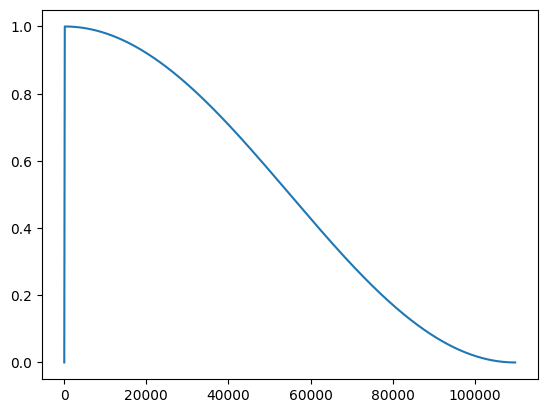

In [14]:
import matplotlib.pyplot as plt
import numpy as np

y = [lr_lambda(current_step) for current_step in range(num_training_steps)]

plt.plot(y)

In [15]:
def compute_logps(prompt_attention_mask, chosen_inputs, chosen_attention_mask, logits):
    mask = prompt_attention_mask[:, 1:] * chosen_attention_mask[:, :-1]
    per_token_logps = torch.gather( logits[:, :-1, :].log_softmax(dim=-1) ,dim=2, index= (mask * chosen_inputs[:, 1:]).unsqueeze(dim = 2) ).squeeze(dim = 2)
    return torch.mul( per_token_logps, mask.to(dtype)).sum(dim = 1).to(dtype) / mask.sum(dim = 1).to(dtype)

In [16]:
# Alignment Training Loop

try :
    for e in range(epochs):
        for i, batch in tqdm(enumerate(train_dataloader), total=len(train_dataloader), dynamic_ncols=True):
            optimizer.zero_grad(set_to_none=True)

            batch["positive_input_ids"] = batch["positive_input_ids"].to(device)
            batch["positive_attention_mask"] = batch["positive_attention_mask"].to(device)
            batch["negetive_input_ids"] = batch["negetive_input_ids"].to(device)
            batch["negetive_attention_mask"] = batch["negetive_attention_mask"].to(device)
            batch["attention_mask"] = batch["attention_mask"].to(device)

            neg_labels = batch['negetive_input_ids'].clone()
            pos_labels = batch['positive_input_ids'].clone()

            # Calculation of Loss

            mask = batch['attention_mask'] * batch['positive_attention_mask'] # so this will basically to creater a mask value where prompt is put 1 rest is 0 same as attention mask. we don't know why creator of this algo suggested this multiplication.
            # mask = batch['attention_mask']
            pos_labels = pos_labels * mask.logical_not()
            # so this will put 0's where the prompt was, and preserver the last answer with padding tokens have value 2. so eventaully we have 0 at prompt, and input_ids of last answer with padding tokens.

            pos_labels[pos_labels == 0] = tokenizer.pad_token_id # eos : 2
            pos_labels[pos_labels == tokenizer.pad_token_id] = -100
            neg_labels[neg_labels == tokenizer.pad_token_id] = -100

            output_pos, loss_pos = model(batch['positive_input_ids'], pos_labels)
            output_neg, _ = model(batch['negetive_input_ids'], neg_labels)

            pos_probs = compute_logps(
                prompt_attention_mask = batch['attention_mask'],
                chosen_inputs= batch['positive_input_ids'],
                chosen_attention_mask = batch['positive_attention_mask'],
                logits= output_pos
            )
            neg_probs = compute_logps(
                prompt_attention_mask = batch['attention_mask'],
                chosen_inputs = batch['negetive_input_ids'],
                chosen_attention_mask = batch['negetive_attention_mask'],
                logits= output_neg
            )

            # Calculate ORPO ODDS RATIO
            # Watch 92 you'll understand everything

            log_odds = (pos_probs - neg_probs) - (torch.log(1 - torch.exp(pos_probs)) - torch.log( 1 - torch.exp(neg_probs)))
            # the compute_logs will return pos_probs with log function that's why its missing here
            # torch.exp is inverse of torch.log that why we use torch.exp to reverse torch.log, subtract them then apply log again in torch.log( 1 - torch.exp(pos_labels ))

            sig_ratio = torch.sigmoid(log_odds)
            ratio = torch.log(sig_ratio)

            # Calculate the final loss
            # we are taking mean as this calculation happen to all logits, and we are taking mean or averate all of them to calcuate the final loss
            loss = torch.mean(loss_pos - (alpha*ratio).mean()).to(dtype=dtype)

            # Logging
            if i % log_iters == 0:
                print(f"Epochs : {e} / {epochs} | Steps : {i} / {len(train_dataloader)} | Train Loss : {loss.item():.3f} | Odds Ratio : {log_odds.mean().item():.3f}")

                if wandb_logging:
                    wandb.log({
                        "train_loss" : loss.item(),
                        "log_odds" : log_odds.mean().item(),
                        "lr" : scheduler.get_last_lr()[0],
                    },
                    step = (e * len(train_dataloader) + i ))
            
            if torch.isnan(loss):
                if wandb_logging:
                    wandb.finish()
                torch.cuda.empty_cache()
                sys.exit(0)
            
            loss.backward()
            nn.utils.clip_grad_norm_(model.parameters(), max_norm=grad_clip)
            optimizer.step()
            scheduler.step()

        sd = model.state_dict()
        sd['config'] = config
        torch.save(sd, os.path.join(checkpoint_dir, f'{project_name}_{e+1}.pt'))


except KeyboardInterrupt:
    print("Training loop interupted... Clearning UP......")

finally :
    torch.cuda.empty_cache()
    print("GPU Memory Released")

if wandb_logging:
    wandb.finish()
torch.cuda.empty_cache()

  0%|          | 0/36622 [00:00<?, ?it/s]

Epochs : 0 / 3 | Steps : 0 / 36622 | Train Loss : 3.141 | Odds Ratio : 0.000
Epochs : 0 / 3 | Steps : 50 / 36622 | Train Loss : 4.406 | Odds Ratio : 0.000
Epochs : 0 / 3 | Steps : 100 / 36622 | Train Loss : 2.078 | Odds Ratio : -0.031
Epochs : 0 / 3 | Steps : 150 / 36622 | Train Loss : 2.500 | Odds Ratio : 0.035
Epochs : 0 / 3 | Steps : 200 / 36622 | Train Loss : 2.328 | Odds Ratio : 0.031
Epochs : 0 / 3 | Steps : 250 / 36622 | Train Loss : 2.422 | Odds Ratio : 0.000
Epochs : 0 / 3 | Steps : 300 / 36622 | Train Loss : 2.906 | Odds Ratio : 0.031
Epochs : 0 / 3 | Steps : 350 / 36622 | Train Loss : 2.156 | Odds Ratio : -0.031
Epochs : 0 / 3 | Steps : 400 / 36622 | Train Loss : 2.531 | Odds Ratio : 0.000
Epochs : 0 / 3 | Steps : 450 / 36622 | Train Loss : 2.266 | Odds Ratio : 0.000
Epochs : 0 / 3 | Steps : 500 / 36622 | Train Loss : 2.719 | Odds Ratio : 0.031
Epochs : 0 / 3 | Steps : 550 / 36622 | Train Loss : 2.969 | Odds Ratio : 0.000
Epochs : 0 / 3 | Steps : 600 / 36622 | Train Loss : 2

  0%|          | 0/36622 [00:00<?, ?it/s]

Epochs : 1 / 3 | Steps : 0 / 36622 | Train Loss : 1.867 | Odds Ratio : 0.000
Epochs : 1 / 3 | Steps : 50 / 36622 | Train Loss : 1.211 | Odds Ratio : 0.000
Epochs : 1 / 3 | Steps : 100 / 36622 | Train Loss : 1.531 | Odds Ratio : -0.114
Epochs : 1 / 3 | Steps : 150 / 36622 | Train Loss : 1.898 | Odds Ratio : 0.082
Epochs : 1 / 3 | Steps : 200 / 36622 | Train Loss : 2.062 | Odds Ratio : -0.098
Epochs : 1 / 3 | Steps : 250 / 36622 | Train Loss : 2.156 | Odds Ratio : 0.000
Epochs : 1 / 3 | Steps : 300 / 36622 | Train Loss : 2.547 | Odds Ratio : 0.160
Epochs : 1 / 3 | Steps : 350 / 36622 | Train Loss : 1.422 | Odds Ratio : 0.067
Epochs : 1 / 3 | Steps : 400 / 36622 | Train Loss : 2.062 | Odds Ratio : 0.051
Epochs : 1 / 3 | Steps : 450 / 36622 | Train Loss : 1.992 | Odds Ratio : 0.020
Epochs : 1 / 3 | Steps : 500 / 36622 | Train Loss : 2.266 | Odds Ratio : 0.185
Epochs : 1 / 3 | Steps : 550 / 36622 | Train Loss : 2.578 | Odds Ratio : 0.082
Epochs : 1 / 3 | Steps : 600 / 36622 | Train Loss : 1

  0%|          | 0/36622 [00:00<?, ?it/s]

Epochs : 2 / 3 | Steps : 0 / 36622 | Train Loss : 1.680 | Odds Ratio : -0.031
Epochs : 2 / 3 | Steps : 50 / 36622 | Train Loss : 0.898 | Odds Ratio : 0.000
Epochs : 2 / 3 | Steps : 100 / 36622 | Train Loss : 1.430 | Odds Ratio : -0.082
Epochs : 2 / 3 | Steps : 150 / 36622 | Train Loss : 1.781 | Odds Ratio : 0.133
Epochs : 2 / 3 | Steps : 200 / 36622 | Train Loss : 1.922 | Odds Ratio : -0.125
Epochs : 2 / 3 | Steps : 250 / 36622 | Train Loss : 2.031 | Odds Ratio : 0.000
Epochs : 2 / 3 | Steps : 300 / 36622 | Train Loss : 2.375 | Odds Ratio : 0.191
Epochs : 2 / 3 | Steps : 350 / 36622 | Train Loss : 1.320 | Odds Ratio : 0.103
Epochs : 2 / 3 | Steps : 400 / 36622 | Train Loss : 1.953 | Odds Ratio : 0.066
Epochs : 2 / 3 | Steps : 450 / 36622 | Train Loss : 1.898 | Odds Ratio : 0.036
Epochs : 2 / 3 | Steps : 500 / 36622 | Train Loss : 2.188 | Odds Ratio : 0.169
Epochs : 2 / 3 | Steps : 550 / 36622 | Train Loss : 2.484 | Odds Ratio : 0.062
Epochs : 2 / 3 | Steps : 600 / 36622 | Train Loss : 

log_odds,▂▂▂▂▃▄▂▅▂▄▂▄▃▂▁▁▂▂▄▂▄▂▂▃▄▁▂▃▂▂▅▂▆▂▅▂▂█▂▃
lr,▃█████████▇▇▇▇▇▆▆▆▆▆▅▅▄▄▄▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁
train_loss,▄▄▃▄▅▄█▄▃▁▅▄▄▃▃▃▄▂▄▃▂▄▄▃▃▄▄▅▁▃▃▄▄▃▃▃▃▄▃▃
log_odds,0.18945
lr,1e-05
train_loss,1.99219
